# Classification of Lymphocytosis from Blood Cells

This work focuses on predicting lymphocyte diagnosis for a patient given two types of data: lymphocyte microscopic images and clinical attributes such as age and lymphocyte concentration, by using deep learning methods. Convolutional neural networks are trained on bags of various size of microscopic images to extract meaningful features whereas a linear classifier is trained to predict the outcome from the clinical data. Moreover, we explore different ways of combining the outputs of each of these classifiers to predict the correct label for a given patient. We face the difficulties of multi-instance learning in a medical context, where even clinicians have variable consensus on the diagnosis. Finally our best results report a balanced accuracy of $78.96\%$ on the private leaderboard. 

## Loading data

Data can be loaded from and set in local directory to execute the following code:

https://www.kaggle.com/c/3md3070-dlmi/data

## Imports

In [1]:
from google.colab import drive
import os 
import pandas as pd
import datetime
import numpy as np
import glob
import random 
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import plotly.express as px
import copy
import tqdm as tqdm
import time

import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# if use of google colab mounted on google drive
#from google.colab import drive
#drive.mount('/content/drive/')
#os.chdir('/content/drive/My Drive')

Mounted at /content/drive/


## Database


### Preprocessing

In [19]:
def characteristics_table(df):
  """Creates a DataFrame that summarizes the characteristics of the DataFrame df"""

  # df retrieving mean and std AGE/LYMPH_COUNT by label
  merged_df = df.query('LABEL >= 0')\
    .pivot_table( index = ['LABEL'], aggfunc = [np.mean, np.std])\
    .apply(lambda x : np.round(x,1))
  merged_df.columns = merged_df.columns.droplevel() + '_' + merged_df.columns.droplevel(1).map(str.upper)
  merged_df.head()

  # df retrieving percentage of gender F
  gender_df = df.query('LABEL >= 0')[['GENDER','ID','LABEL']]\
    .groupby(['LABEL','GENDER'])\
    .count()\
    .rename(columns={'ID':'COUNT'})\
    .reset_index()\
    .pivot_table(index = 'LABEL',columns ='GENDER', aggfunc = np.sum)
  gender_df.columns = gender_df.columns.droplevel(0)
  gender_df = gender_df.assign( PctSexF = lambda gender_df : np.round(100* gender_df.F / (gender_df.F + gender_df.M),1))\
    .drop(columns = ['F','M'])

  merged_df = merged_df.merge(gender_df, left_index = True, right_index = True)

  return merged_df

In [20]:
# import data 
df = pd.read_csv('clinical_annotation_cleaned.csv',index_col = 'Unnamed: 0')

# test set ( label in {-1})
test_df = df[df.LABEL == -1].reset_index(drop=True)\
  .copy()

# training set ( label in {0,1})
df = df[df.LABEL >= 0].reset_index(drop=True) 
df.head(4)

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P26,1,M,1933-11-03,11.2,87.4
1,P183,1,M,1942-05-15,12.8,78.9
2,P89,1,M,1935-06-19,9.6,85.8
3,P123,1,M,1931-01-27,122.6,90.2


In [21]:
characteristics_table(df)

,AGE_MEAN,LYMPH_COUNT_MEAN,AGE_STD,LYMPH_COUNT_STD,PctSexF
LABEL,,,,,
0,55.1,5.0,19.8,1.0,52.0
1,76.0,35.9,12.1,53.6,48.7


### Data visualization

In [22]:
fig = px.box(df.query('LABEL >=0'), y="LYMPH_COUNT",x ='LABEL',title = 'Lymphocyte count by label')
fig.show()
fig = px.box(df.query('LABEL >=0'), y="AGE",x ='LABEL',title = 'Age by label', points = 'all')
fig.show()

In [23]:
def build_image_df(df):
  """
  Retrieves a dataframe which links all images to their respective patient and it's clinical information
  The data needs to be in the current directory
  Parameters: 
    - df: dataframe, dataframe associated to the database of patients
  """
  # builds a dataframe merging information on patient and each image
  img_paths = []
  patient_ids = []
  for img_path in glob.glob('./*/P*/*.jpg'):
    patient_id = str(img_path.split('/')[-2])
    img_paths.append(img_path)
    patient_ids.append(patient_id)
  image_df = pd.DataFrame(list(zip(img_paths,patient_ids)), columns = ['img_dir','ID'])\
    .merge(df, how ='inner', left_on='ID',right_on='ID')
  return image_df

def vizualize_random_data(nb_samples, label, image_df ):
    """
    Plots a random number of samples for a given label
    Args: - nb_samples : (int), number of samples 
          - label: (str), label to plot 
          - image_df: (dataframe), dataframe containing information on all images
    """
    assert label in ['0','1']

    image_df = image_df.query('LABEL == @label')

    # select random subset of images
    images_to_plot = random.sample(list(image_df.img_dir.values), nb_samples)

    # plot the sample of images 
    n_cols = 5
    n_rows = nb_samples//n_cols
    fig = plt.figure(figsize=(n_cols*3,n_rows*3))
    for idx in range(1,nb_samples+1):
      image_path = images_to_plot[idx-1]
      image = Image.open(image_path)
      plt.subplot(n_rows,n_cols,idx)
      plt.imshow(image)
      plt.axis('off')
      plt.title('ID: '+ image_path.split('/')[2] )
      plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('Label: '+ label)
    plt.show()

def vizualise_patient(patient_id, nb_samples, image_df, all = False, title = None):
    """
    Plots a random number of samples for a given patient
    Args: - patient_id : (str), ID of patient in format 'P' + int
          - nb_samples : (int), number of samples (at least 5)
          - all: (Boolean), whether to plot all images associated to the patient or not
          - image_df= (Dataframe), retrieving all images to each patient
    """

    image_df = image_df.query('ID == @patient_id')
    if not title:
      title = 'ID: '+ image_path.split('/')[2]+', LABEL: ' +str(image_df['LABEL'].values[0])

    # select random subset of images
    images_to_plot = random.sample(list(image_df.img_dir.values), nb_samples)

    # plot the sample of images 
    if nb_samples <5:
      nb_samples = 5
    n_cols = 5
    n_rows = nb_samples//n_cols
    fig = plt.figure(figsize=(n_cols*3,n_rows*3))
    for idx in range(1,nb_samples+1):
      image_path = images_to_plot[idx-1]
      image = Image.open(image_path)
      plt.subplot(n_rows,n_cols,idx)
      plt.imshow(image)
      plt.axis('off')
      plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle(title)
    plt.show()

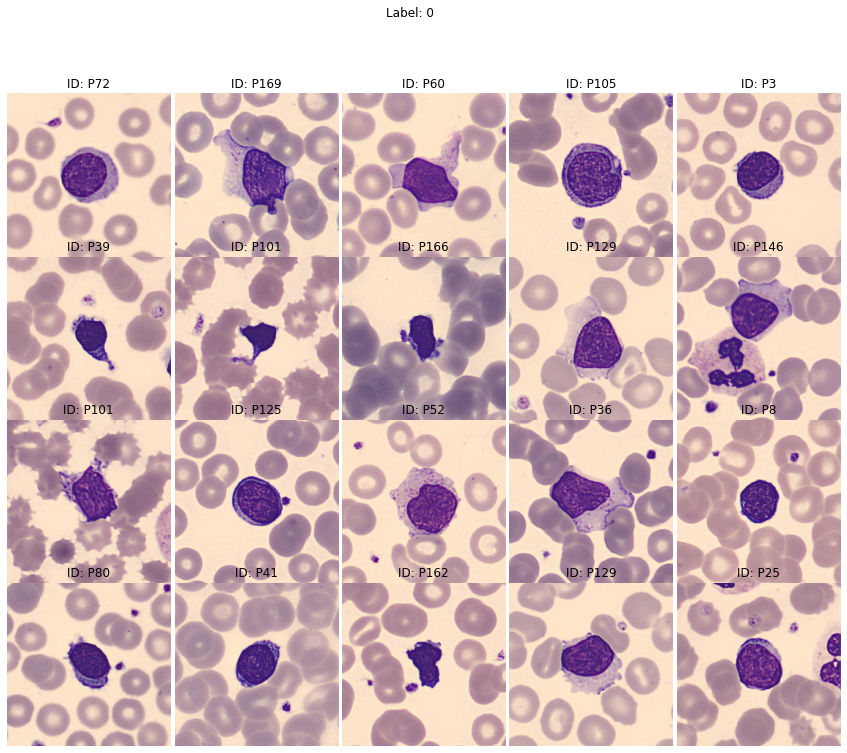

In [25]:
# build dataframe with information on each image file ( patient_ID, label etc.)
image_df = build_image_df(df)
nb_samples = 20
label = '0'

# plot random images of label 0
vizualize_random_data(nb_samples, label, image_df )

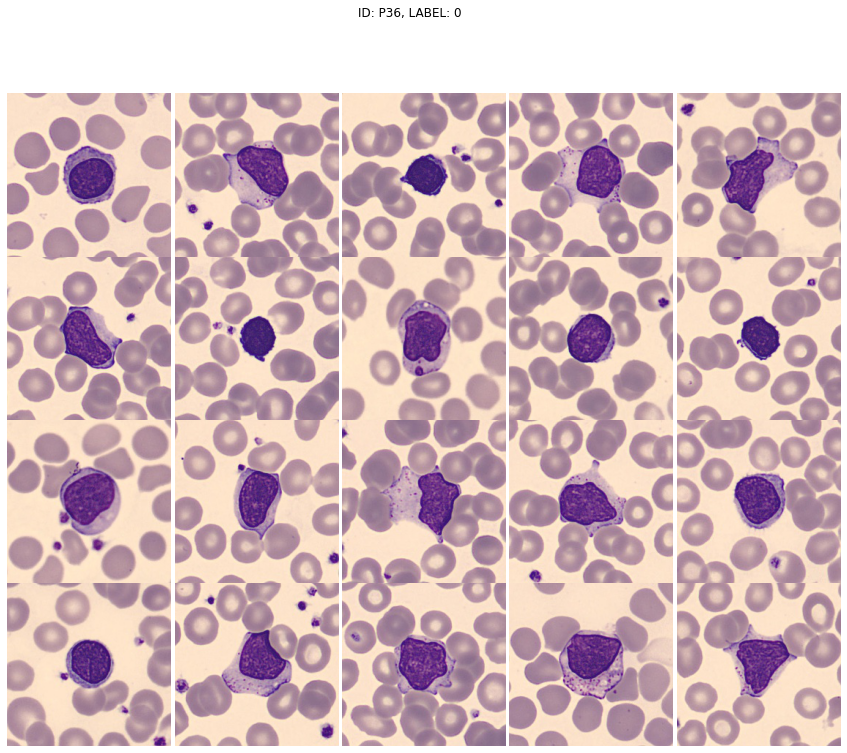

In [ ]:
# visualize 20 random images of patient ID: P35
vizualise_patient('P36', 20, image_df, all = False)

### Custom Dataset

In [26]:
class LymphoDataset(torch.utils.data.Dataset):
    """
    This dataset includes :
    - preprocessing functions for the data
    - classic functions for data
    Args: - img_dir: (str), directory to images 
          - df: (dataframe), dataframe retrieving clinical information on patients
          - transforms: (torchvision.transforms), transforms to apply to the images, data augmentation
    """
    def __init__(self, img_dir, df, transforms=None):
        self.transforms = transforms
        self.img_list = df.ID.values.tolist()
        self.img_dict = {idx: {'paths': [img_dir + patient_id + '/' + img_name for img_name in os.listdir(img_dir + patient_id)],
                               'age': df.loc[idx,'AGE'],
                               'lymph_count': df.loc[idx,'LYMPH_COUNT'],
                               'label': df.loc[idx,'LABEL'],
                               'patient_id': patient_id} for idx, patient_id in enumerate(self.img_list)}

    def load_image(self, path):
        image = imageio.imread(path)
        return image


    def __getitem__(self, image_id):   
        images = [self.load_image(path) for path in self.img_dict[image_id]['paths']]
        label = self.img_dict[image_id]['label']
        age = self.img_dict[image_id]['age']
        lymph_count = self.img_dict[image_id]['lymph_count']
        patient_id = self.img_dict[image_id]['patient_id']

        # Convert everything to tensor
        lymph_count = torch.tensor([lymph_count], dtype=torch.float32)
        age = torch.as_tensor([age], dtype=torch.float32)
        label = torch.as_tensor([label], dtype=torch.long)

        if self.transforms:
            images = torch.cat([self.transforms(image)[None, :, :, :] for image in images], axis=0)
        
        data = {"age": age,
                "lymph_count": lymph_count,
                "images": images,
                "label": label,
                "patient_id": patient_id}
        return data

    def __len__(self):

      return len(self.img_list)

### Data augmentation

In [27]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToPILImage())
    transforms.append(T.Resize(224))

    if train:
      transforms.append(T.RandomAffine(degrees=20))
      transforms.append(T.RandomHorizontalFlip())
      transforms.append(T.RandomVerticalFlip())
                                   
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225]))
    return T.Compose(transforms)
    
def gen_list(key, batch):
  if key == 'images':
    return [d[key][:, :, :, :] for d in batch]
  elif key =='patient_id':
    return [d[key] for d in batch]
  else:
    return [d[key][None, :] for d in batch]

def custom_fn(batch):
  elem = batch[0].keys()
  return {key : torch.cat(gen_list(key, batch), axis=0) if key != 'patient_id' else gen_list(key, batch) for key in elem}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


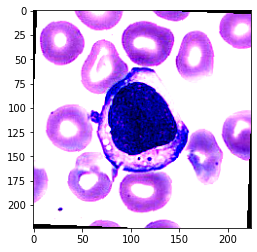

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


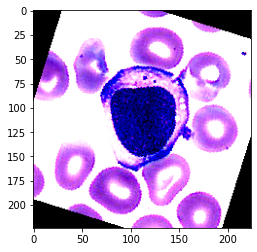

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


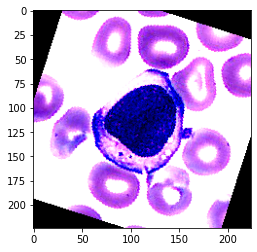

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


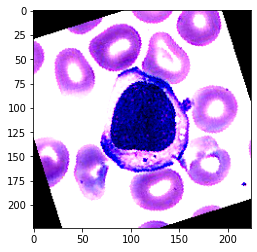

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


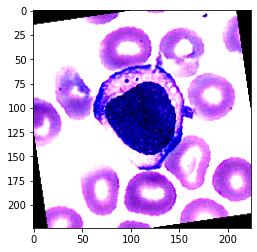

In [ ]:
# visualize data augmentation
path = glob.glob('./trainset/*/*.jpg')[0]

for i in range(5):
  image = imageio.imread(path)
  image = get_transform(True)(image)
  plt.imshow(image.permute(2,1,0))
  plt.show()

### Creating train and validation split

Here we split the training data into a validation and training set by beeing careful to stratify the patients following their label, lymphocyte count and age group. As the genders were already balanced there wasn't need to balance the data on the gender criteria. However, we introduced age groups in order to have a good representation of the patient population in both the training and validation set. 

In [ ]:
def create_train_split(df, aggregation, train_valid_split, random_state):
  """
  Args: 
        - df: (DataFrame) dataframe to split into a training and validation set
        - aggregation: (List of str) list of attributes on which to split the data on
        - train_valid_state: (float) proportion of data to keep for validation, float between 0 and 1
        - random_state: (int) random state
  Returns:
        - training_df, vaidation_df : (DataFrame) two dataframes for training and validation
  """
  analysis_group = df.groupby(aggregation)
  train_df, valid_df = pd.DataFrame(), pd.DataFrame()

  for idx,df_ in analysis_group:
    if df_.shape[0] > 1:
      train, valid = train_test_split(df_, test_size = train_valid_split, random_state = random_state)
    else:
      train, valid = df_, None
    
    train_df = train_df.append(train)
    valid_df = valid_df.append(valid)

  return train_df.reset_index(), valid_df.reset_index()
 
# split data into training and test dataframes 
seed = 42
train_labels = ['0','1']
test_labels = ['-1']
#test_df = df.query('LABEL in @test_labels')
df = df.query('LABEL in @train_labels')

# create age categories 
bins = np.arange(0,110,10)
labels = np.arange(1,11,1)
df['AGE_GROUP'] = pd.cut(df['AGE'],bins = bins, labels = labels)

# creating training and validation set 
# splitting on the labels, genders and age groups in order to have stratified data 


train_df, valid_df = create_train_split(df, ['LABEL','GENDER','AGE_GROUP'], 0.2, seed)



In [ ]:
characteristics_table(train_df)

,AGE_MEAN,LYMPH_COUNT_MEAN,index_MEAN,AGE_STD,LYMPH_COUNT_STD,index_STD,PctSexF
LABEL,,,,,,,
0,55.9,4.9,116.6,20.5,0.9,38.7,52.8
1,75.7,31.9,69.6,11.6,44.3,41.2,48.2


In [ ]:
characteristics_table(valid_df)

,AGE_MEAN,LYMPH_COUNT_MEAN,index_MEAN,AGE_STD,LYMPH_COUNT_STD,index_STD,PctSexF
LABEL,,,,,,,
0,52.9,5.2,99.2,18.3,1.3,36.2,50.0
1,76.0,47.6,58.7,13.2,76.2,53.0,48.1


### Dataloaders

In [ ]:
# batch size of 1 patient to load the data
batch_size = 1
img_train_dir = './trainset/'
img_test_dir = './testset/'

train_dataset = LymphoDataset(img_train_dir, train_df, get_transform(True))
valid_dataset = LymphoDataset(img_train_dir, valid_df, get_transform(True))
test_dataset = LymphoDataset(img_test_dir, test_df, get_transform(False))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = 2,
                                           collate_fn = custom_fn)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 2,
                                           collate_fn = custom_fn)


test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 2,
                                           collate_fn = custom_fn)


print('Number of patients in:\n')
print('- Training set: ',len(train_loader),'\n')
print('- Validation set: ',len(valid_loader),'\n')
print('- Test set: ',len(test_loader),'\n')


Number of patients in:

- Training set:  121 

- Validation set:  41 

- Test set:  42 



## A first Model

In [29]:
class MIL(nn.Module):
  """
  Multi Instance Level model.
  Applies an aggregation function on the outputs of the batch presented
  to the model.
  Parameters:
              - n_classes: number of classes to predict
              - pool_func: aggregation/pooling function to apply to the outputs at instance level
  """

  def __init__(self, n_classes, pool_func):

    super(MIL, self).__init__()
    self.n_classes = n_classes
    self.pool_func = pool_func
    self.model_ft = models.resnet18(pretrained = True)
    for name, child in self.model_ft.named_children():
        for param in child.parameters():
            param.requires_grad = True

    self.num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Sequential(nn.Dropout(p = 0.2),nn.Linear(self.num_ftrs,self.n_classes))

  def forward(self, input):
    output = self.model_ft(input)
    if self.pool_func == 'mean':
      output = torch.mean(output, dim = 0, keepdim = True)
    if self.pool_func == 'max':
      output = torch.max(output, dim = 0).values.unsqueeze(0)
    return output

class MIL_Embedding(nn.Module):
  """
  Multi Instance Level model.
  Applies an aggregation function on the embeddings built from each image of the batch presented
  to the model.
  Parameters:
              - embedding_size: size of the embedding or feature vector to build from each image
              - n_classes: number of classes to predict
              - pool_func: aggregation/pooling function to apply to the outputs at instance level
  """


  def __init__(self, embedding_size, n_classes, pool_func):
    super(MIL_Embedding, self).__init__()
    self.n_classes = n_classes
    self.embedding_size = embedding_size
    self.pool_func = pool_func

    self.model_ft = models.resnet18(pretrained = True)
    for name, child in self.model_ft.named_children():
        for param in child.parameters():
            param.requires_grad = True

    self.num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Sequential(nn.Dropout(0.2),
                                     nn.Linear(self.num_ftrs,self.embedding_size))
    self.classifier = nn.Linear(self.embedding_size, self.n_classes)

                          
  def forward(self, input):
    # extracting features for each image of the bag
    features = self.model_ft(input)
    
    # create an only embedding
    # pooling over features by keeping the dimensions of the feature vectors
    if self.pool_func == 'mean':
      pooled_embedding = torch.mean(features, dim = 0, keepdim = True)
    if self.pool_func == 'max':
      pooled_embedding = torch.max(features, dim = 0).values.unsqueeze(0)
    
    # binary classification
    output = self.classifier(pooled_embedding)
    
    return output

class MLP(nn.Module):
  """
  Multi Layer Perceptron with two hidden layers with respectively h1 and h2 neurons
  Parameters:
              - n_classes: number of classes to predict
              - h1: number of neurons of the first hidden layer
              - h2: number of neurons of the second hidden layer
  """
  def __init__(self, n_classes, h1, h2):
    super(MLP,self).__init__()
    self.n_classes = n_classes
    self.h1 = h1
    self.h2 = h2
    self.classifier = nn.Sequential(nn.Linear(2,self.h1),
                                    nn.ReLU(),
                                    nn.Linear(self.h1, self.h2),
                                    nn.ReLU(),
                                    nn.Linear(self.h2, self.n_classes))
    
  def forward(self, input):

    return self.classifier(input)

class MultiMIL(nn.Module):
  """
  Multi Instance Level model with concatenation of the outputs of an mLPon clinical data
  Applies an aggregation function on the embeddings built from each image of the batch presented
  to the model.
  Parameters:
              - embedding_size: size of the embedding or feature vector to build from each image
              - n_classes: number of classes to predict
              - pool_func: aggregation/pooling function to apply to the outputs at instance level
              - h1: number of neurons of the first hidden layer
              - h2: number of neurons of the second hidden layer
  """

  def __init__(self, embedding_size, n_classes, h1, h2, pool_func):
    super(MultiMIL, self).__init__()
    self.n_classes = n_classes
    self.embedding_size = embedding_size
    self.h1 = h1
    self.h2 = h2
    self.pool_func = pool_func

    self.model_ft = models.resnet18(pretrained = True)
    for name, child in self.model_ft.named_children():
        for param in child.parameters():
            param.requires_grad = True

    self.num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = self.model_ft.fc = nn.Sequential(nn.Dropout(0.2),
                                          nn.Linear(self.num_ftrs,self.embedding_size))
    self.classifier = nn.Linear(self.embedding_size, self.n_classes)
    self.MLP = nn.Sequential(nn.Linear(2, self.h1),
                             nn.ReLU(),
                             nn.Linear(self.h1, self.h2),
                             nn.ReLU(),
                             nn.Linear(self.h2, self.n_classes)
                             )

                          
  def forward(self, images, clinical_data):
    # extracting features for each image of the bag
    features = self.model_ft(images)
    
    # create an only embedding
    # pooling over features by keeping the dimensions of the feature vectors
    if self.pool_func == 'mean':
      pooled_embedding = torch.mean(features, dim = 0, keepdim = True)
    if self.pool_func == 'max':
      pooled_embedding = torch.max(features, dim = 0).values.unsqueeze(0)
    
    # binary classification on images and clinical data
    images_output = self.classifier(pooled_embedding)
    data_output = self.MLP(clinical_data)
    
    # concatenate outputs + mean prediction
    output = torch.cat((images_output, data_output), dim = 0)
    mean_output = torch.mean(output, dim = 0, keepdim = True)

    return mean_output

In [ ]:
model = MIL_Embedding(embedding_size = 20, n_classes = 2, pool_func = 'mean')
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

## Training

### Training loop

In [ ]:
def train_loop(loader, model, epoch, batch_size, criterion, optimizer, multi_mode = False, attention = False):
  """
    Method used to train and evaluate a CNN loop
    
    Args:
        loader: (DataLoader) a DataLoader wrapping a LymphoDataset
        model: (nn.Module) the neural network
        epochs: (int) epoch of training
        batch_size: (int) number of patients to integrate for backpropagation
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        multi_data: (Boolean) whether to use all the data (images and clinical data) or not
        
    Returns:
        results_df: (pd.DataFrame) dataframe retrieveing metrics on the training during the epoch
    """
  total_loss = 0

  columns = ["epoch","patient_id", "proba0", "proba1", "true_label", "pred_label"]
  df_rows = []
  attention_scores = []


  for idx, batch in enumerate(loader):
    bag, label = batch['images'].squeeze().cuda(), batch['label'].cuda()
    

    if multi_mode :
      lymph_count, age = batch['lymph_count'], batch['age']
      clinical_data = torch.cat((lymph_count,age), axis = 1).cuda()
      if attention:
        output, A = model(bag, clinical_data)
      else:
        output = model(bag, clinical_data)

    else:
      if attention:
        output, A = model(bag)
        attention_scores.append(A)
      else:
        output = model(bag)

    optimizer.zero_grad()
    loss = criterion(output, label.squeeze(1))
    total_loss += loss.item()

    if model.training:
      loss.backward()
      optimizer.step()

    probs = nn.Softmax(dim = 1)(output)
    _, pred = torch.max(probs, 1, keepdim = True)
  
    # storing results
    row = [epoch, batch['patient_id'][0], probs.squeeze()[0].item(), probs.squeeze()[1].item(),
           label.reshape(1).item(), pred.reshape(1).item()]
    df_rows.append(row)
      
  total_loss /= len(loader)
  results_df = pd.DataFrame(df_rows, columns = columns)
  results_df['loss'] = total_loss
  
  return results_df

def compute_metrics(ground_truth, prediction):

    """
    Computes the accuracy, sensitivity, specificity and balanced accuracy
    Parameters:
          ground_truth: (list), list of ground truth labels
          prediction: (list), list of predicted layers
    """

    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))
    
    metrics_dict = dict()
    metrics_dict['acc'] = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sens'] = tp / (tp + fn)
    else:
        metrics_dict['sens'] = 0.0
        
    # Specificity
    if fp + tn != 0:
        metrics_dict['spec'] = tn / (fp + tn)
    else:
        metrics_dict['spec'] = 0.0
        
    metrics_dict['bal_acc'] = (metrics_dict['sens'] + metrics_dict['spec']) / 2
    
    return metrics_dict

def dict2df(train_dico,val_dico):
  train_dico = {f'train_{k}': v for k, v in train_dico.items()}
  val_dico = {f'val_{k}': v for k, v in val_dico.items()}
  train_dico.update(val_dico)
  return  pd.DataFrame([train_dico])


### Plotting functions 

In [ ]:
def plot_acc(experiment_path):
  """
  plots the accuracy of the model, and saves the figure
  Parameters:(str), path to experiment 
  """
  H = pd.read_csv(experiment_path+'/history.csv')
  fig = plt.figure(figsize=(5,5))
  plt.plot(H['epoch'],H['train_bal_acc'],H['val_bal_acc'])
  plt.legend(["Training","Validation"])
  plt.title("Balanced Accuracy")
  plt.xlabel('Epoch')
  plt.ylabel('Balanced Accuracy(%)')
  plt.savefig(experiment_path+ '/fig_acc.png')
  plt.show()

def plot_loss(experiment_path):
  """
  plot the loss of the model
  Parameters:(str), path to experiment  
  """
  H = pd.read_csv(experiment_path+'/history.csv')
  fig = plt.figure(figsize=(5,5))
  plt.plot(H['epoch'],H['train_loss'],H['val_loss'])
  plt.legend(["Training","Validation"])
  plt.title("Loss")
  plt.xlabel('Epoch')
  plt.ylabel('Binary Cross Entropy')
  plt.savefig(experiment_path+ '/fig_loss.png')
  plt.show()


### Training Parameters

In [ ]:
# training parameters
# experiment path for saving model weights, training history and validation metrics

# chose experiment path name to store history and best model weights
EXPERIMENT_PATH = './Experiments/CNN_Resnet18_drop0.2'
EPOCHS = 50
INIT_LR = 1e-4
MOMENTUM = 0.9
BS = 1

w_0 = len(train_df.query('LABEL == 1'))/(len(train_df))
w_1 = len(train_df.query('LABEL == 0'))/(len(train_df))

# if weight of classes needed for training 
weight = torch.tensor([w_0,w_1]).cuda()
print('Class weights:', weight)

criterion = nn.CrossEntropyLoss( reduction ='mean')
optimizer = optim.Adam(model.parameters(), lr = INIT_LR , weight_decay = 5e-4)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda,verbose = True)



Class weights: tensor([0.7025, 0.2975], device='cuda:0')
Adjusting learning rate of group 0 to 1.0000e-04.


In [ ]:
# multi data as input 
multi_mode = False
best_valid_acc = 0.
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()
history_df = pd.DataFrame(None)

if not os.path.isdir(EXPERIMENT_PATH) :
      os.mkdir(EXPERIMENT_PATH)

for epoch in range(1, EPOCHS+1):

  model.train()
  train_results = train_loop(train_loader, model, epoch, BS, criterion, optimizer, multi_mode)
  train_metrics = compute_metrics(train_results.true_label.values, train_results.pred_label.values)
  train_metrics['loss'] = train_results['loss'].values[0]

  with torch.no_grad(): 
    model.eval()
    val_results = train_loop(valid_loader, model, epoch, BS, criterion, optimizer, multi_mode )
    val_metrics = compute_metrics(val_results.true_label.values, val_results.pred_label.values)
    val_metrics['loss'] = val_results['loss'].values[0]

  print('Epoch: [{}/{}] \tTraining Loss :{:.6f} \tBalAcc. :{:.6f} \tVal Loss : {:.6f} \tBalAcc. :{:.6f} '.format(epoch, EPOCHS, train_metrics['loss'], train_metrics['bal_acc'],
                                                                                                           val_metrics['loss'], val_metrics['bal_acc']))
  
  epoch_df = dict2df(train_metrics,val_metrics)\
    .assign(epoch = epoch)
  history_df = history_df.append(epoch_df)
  history_df.to_csv(EXPERIMENT_PATH + '/history.csv')

  # saving best model to EXPERIMENT_PATH/best_model_acc.pth
  if val_metrics['bal_acc'] >= best_valid_acc:
    model_file = EXPERIMENT_PATH + '/best_model_'+str(np.round(val_metrics['bal_acc'],2))+'.pth'
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(best_model_wts, EXPERIMENT_PATH + '/best_model.pth') 
    #torch.save(best_model_wts, model_file)
 
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch: [1/50] 	Training Loss :0.622814 	BalAcc. :0.500000 	Val Loss : 0.642349 	BalAcc. :0.500000 
Epoch: [2/50] 	Training Loss :0.618861 	BalAcc. :0.500000 	Val Loss : 0.641268 	BalAcc. :0.500000 
Epoch: [3/50] 	Training Loss :0.604463 	BalAcc. :0.500000 	Val Loss : 0.644128 	BalAcc. :0.500000 
Epoch: [4/50] 	Training Loss :0.604449 	BalAcc. :0.500000 	Val Loss : 0.714639 	BalAcc. :0.500000 
Epoch: [5/50] 	Training Loss :0.553845 	BalAcc. :0.529902 	Val Loss : 0.786421 	BalAcc. :0.568783 
Epoch: [6/50] 	Training Loss :0.556786 	BalAcc. :0.557680 	Val Loss : 0.749609 	BalAcc. :0.619048 
Epoch: [7/50] 	Training Loss :0.492149 	BalAcc. :0.621242 	Val Loss : 0.808890 	BalAcc. :0.583333 
Epoch: [8/50] 	Training Loss :0.482007 	BalAcc. :0.649020 	Val Loss : 0.652897 	BalAcc. :0.710317 
Epoch: [9/50] 	Training Loss :0.464503 	BalAcc. :0.645261 	Val Loss : 1.001034 	BalAcc. :0.616402 
Epoch: [10/50] 	Training Loss :0.428256 	BalAcc. :0.710948 	Val Loss : 0.883681 	BalAcc. :0.604497 
Epoch: [1

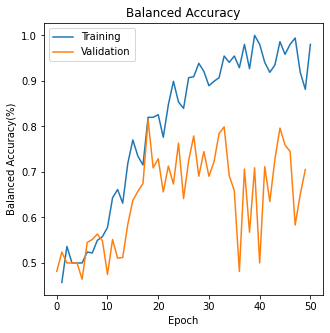

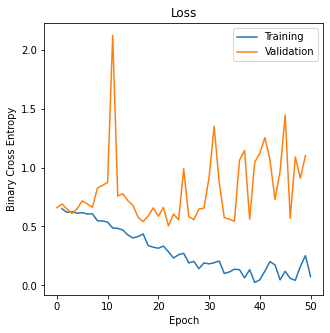

In [ ]:
EXPERIMENT_PATH = './Experiments/MIL_Emb_Resnet18_drop0.2_weight'

plot_acc(EXPERIMENT_PATH)
plot_loss(EXPERIMENT_PATH)

## MIL with Gated attention

### Model

In [ ]:
class ImgEmbedding(nn.Module):

  def __init__(self, embedding_size):
    super(ImgEmbedding, self).__init__()
    self.embedding_size = embedding_size

    self.model_ft = models.resnet18(pretrained = True)
    for name, child in self.model_ft.named_children():
        for param in child.parameters():
            param.requires_grad = True

    self.num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Sequential(nn.Dropout(0.25),
                                     nn.Linear(self.num_ftrs,self.embedding_size))

  def forward(self, input):
    # extracting features for each image of the bag
    output = self.model_ft(input)
    return output

class GatedAttention(nn.Module):
    def __init__(self):
        super(GatedAttention, self).__init__()
        self.resnet_model=ImgEmbedding(embedding_size = 1024)
        self.L = 1024
        self.D = 128
        self.K = 1
        self.n1_channels = 1
        self.n2_channels = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Sigmoid()
        )

        self.attention_weights = nn.Linear(self.D, self.K)

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 2),
            #nn.Sigmoid() # Use only with BCE
        )

    def forward(self, bag):

        x = self.resnet_model(bag) # Size : 1024
        H = x
        A_V = self.attention_V(H)  # NxD
        A_U = self.attention_U(H)  # NxD
        A = self.attention_weights(A_V * A_U) # element wise multiplication # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim = 1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)

        return  Y_prob, A

    

### Parameters

In [ ]:
EXPERIMENT_PATH = './Experiments/GatedAttention_resnet18_dropout0.25'
model = GatedAttention().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)
criterion = nn.CrossEntropyLoss()
EPOCHS = 50


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Training

In [ ]:
# multi data as input 
# embedding = 20
multi_mode = False
best_valid_acc = 0.
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()


history_df = pd.DataFrame(None)

if not os.path.isdir(EXPERIMENT_PATH) :
      os.mkdir(EXPERIMENT_PATH)

for epoch in range(1, EPOCHS+1):

  model.train()
  train_results = train_loop(train_loader, model, epoch, BS, criterion, optimizer, multi_mode, attention = True)
  train_metrics = compute_metrics(train_results.true_label.values, train_results.pred_label.values)
  train_metrics['loss'] = train_results['loss'].values[0]

  with torch.no_grad(): 
    model.eval()
    val_results = train_loop(valid_loader, model, epoch, BS, criterion, optimizer, multi_mode, attention = True )
    val_metrics = compute_metrics(val_results.true_label.values, val_results.pred_label.values)
    val_metrics['loss'] = val_results['loss'].values[0]

  print('Epoch: [{}/{}] \tTraining Loss :{:.6f} \tBalAcc. :{:.6f} \tVal Loss : {:.6f} \tBalAcc. :{:.6f} '.format(epoch, EPOCHS, train_metrics['loss'], train_metrics['bal_acc'],
                                                                                                           val_metrics['loss'], val_metrics['bal_acc']))
  
  epoch_df = dict2df(train_metrics,val_metrics)\
    .assign(epoch = epoch)
  history_df = history_df.append(epoch_df)
  history_df.to_csv(EXPERIMENT_PATH + '/history.csv')

  # saving best model to EXPERIMENT_PATH/best_model_acc.pth
  if val_metrics['bal_acc'] >= best_valid_acc:
    model_file = EXPERIMENT_PATH + '/best_model_'+str(np.round(val_metrics['bal_acc'],2))+'.pth'
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(best_model_wts, EXPERIMENT_PATH + '/best_model.pth') 
    #torch.save(best_model_wts, model_file)
 
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch: [1/50] 	Training Loss :0.693636 	BalAcc. :0.478595 	Val Loss : 0.670950 	BalAcc. :0.500000 
Epoch: [2/50] 	Training Loss :0.701483 	BalAcc. :0.532516 	Val Loss : 0.661691 	BalAcc. :0.500000 
Epoch: [3/50] 	Training Loss :0.596394 	BalAcc. :0.559804 	Val Loss : 0.735589 	BalAcc. :0.500000 
Epoch: [4/50] 	Training Loss :0.582532 	BalAcc. :0.524020 	Val Loss : 0.690431 	BalAcc. :0.500000 
Epoch: [5/50] 	Training Loss :0.574860 	BalAcc. :0.653758 	Val Loss : 0.660928 	BalAcc. :0.500000 
Epoch: [6/50] 	Training Loss :0.500593 	BalAcc. :0.631373 	Val Loss : 0.970043 	BalAcc. :0.500000 
Epoch: [7/50] 	Training Loss :0.643961 	BalAcc. :0.526634 	Val Loss : 0.702574 	BalAcc. :0.500000 
Epoch: [8/50] 	Training Loss :0.487913 	BalAcc. :0.651144 	Val Loss : 0.916272 	BalAcc. :0.345238 
Epoch: [9/50] 	Training Loss :0.484099 	BalAcc. :0.635621 	Val Loss : 0.807077 	BalAcc. :0.500000 
Epoch: [10/50] 	Training Loss :0.448444 	BalAcc. :0.760621 	Val Loss : 0.927277 	BalAcc. :0.500000 
Epoch: [1

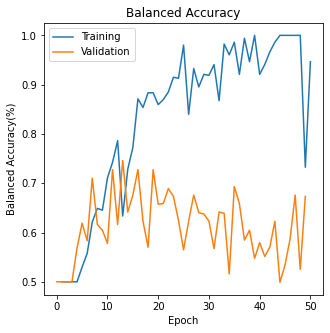

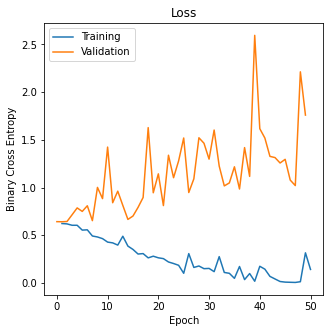

In [ ]:
plot_acc(EXPERIMENT_PATH)
plot_loss(EXPERIMENT_PATH)

## MIL with Gates Attention + MLP 

### Model


In [ ]:
class MLP(nn.Module):
  def __init__(self, n_classes, h1, h2):
    super(MLP,self).__init__()
    self.n_classes = n_classes
    self.h1 = h1
    self.h2 = h2
    self.classifier = nn.Sequential(nn.Linear(2,self.h1),
                                    nn.ReLU(),
                                    nn.Linear(self.h1, self.h2),
                                    nn.ReLU(),
                                    nn.Linear(self.h2, self.n_classes))
    
  def forward(self, input):

    return self.classifier(input)


class GatedAttention_MLP(nn.Module):
    def __init__(self):
        super(GatedAttention_MLP, self).__init__()
        self.resnet_model = ImgEmbedding(embedding_size = 1024)
        self.MLP = MLP(n_classes = 2, h1 = 100, h2 = 100)
        self.L = 1024
        self.D = 128
        self.K = 1
        self.n1_channels = 1
        self.n2_channels = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Sigmoid()
        )

        self.attention_weights = nn.Linear(self.D, self.K)

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 2),
            #nn.Sigmoid() # Use only with BCE
        )
        self.combine = nn.Linear(4,2)

    def forward(self, bag, clinical_data):

        H = self.resnet_model(bag) # Size : 1024
        A_V = self.attention_V(H)  # NxD
        A_U = self.attention_U(H)  # NxD
        A = self.attention_weights(A_V * A_U) # element wise multiplication # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        print('Y_prob gated attention classifier :',Y_prob)

        Y_prob_cd = self.MLP(clinical_data)
        print('Y_prob MLP classifier :',Y_prob)


        output = torch.cat((Y_prob , Y_prob_cd), dim = 0)
        output = self.combine(output)
        #mean_output = torch.mean(output, dim = 0, keepdim = True)
        print('Y_prob mean :',Y_prob)


        return mean_output, A

    

### Training

In [ ]:
EXPERIMENT_PATH = './Experiments/GatedAttention_MLP_resnet18_drop0.5'
model = GatedAttention_MLP().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)
criterion = nn.CrossEntropyLoss()
EPOCHS = 50
BS = 1


In [ ]:
# multi data as input 
# embedding = 20
multi_mode = True
best_valid_acc = 0.
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()


history_df = pd.DataFrame(None)

if not os.path.isdir(EXPERIMENT_PATH) :
      os.mkdir(EXPERIMENT_PATH)

for epoch in range(1, EPOCHS+1):

  model.train()
  train_results = train_loop(train_loader, model, epoch, BS, criterion, optimizer, multi_mode, attention = True)
  train_metrics = compute_metrics(train_results.true_label.values, train_results.pred_label.values)
  train_metrics['loss'] = train_results['loss'].values[0]

  with torch.no_grad(): 
    model.eval()
    val_results = train_loop(valid_loader, model, epoch, BS, criterion, optimizer, multi_mode, attention = True )
    val_metrics = compute_metrics(val_results.true_label.values, val_results.pred_label.values)
    val_metrics['loss'] = val_results['loss'].values[0]

  print('Epoch: [{}/{}] \tTraining Loss :{:.6f} \tBalAcc. :{:.6f} \tVal Loss : {:.6f} \tBalAcc. :{:.6f} '.format(epoch, EPOCHS, train_metrics['loss'], train_metrics['bal_acc'],
                                                                                                           val_metrics['loss'], val_metrics['bal_acc']))
  
  epoch_df = dict2df(train_metrics,val_metrics)\
    .assign(epoch = epoch)
  history_df = history_df.append(epoch_df)
  history_df.to_csv(EXPERIMENT_PATH + '/history.csv')

  # saving best model to EXPERIMENT_PATH/best_model_acc.pth
  if val_metrics['bal_acc'] >= best_valid_acc:
    model_file = EXPERIMENT_PATH + '/best_model_'+str(np.round(val_metrics['bal_acc'],2))+'.pth'
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(best_model_wts, EXPERIMENT_PATH + '/best_model.pth') 
    #torch.save(best_model_wts, model_file)
 
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

NameError: ignored

## Evaluation

### Load best model

In [ ]:
batch_size = 1
model = MIL_Embedding(embedding_size = 2, n_classes = 2, pool_func = 'mean')

criterion = nn.CrossEntropyLoss() 
EXPERIMENT_PATH = './Experiments/CNN_Resnet18_drop0.2'

model.load_state_dict(torch.load(EXPERIMENT_PATH + '/best_model.pth'))
model = model.cuda()


### Evaluation

In [ ]:
def evaluate_model(loader, model, batch_size, criterion, multi_mode = False, attention = False):
  """
    Method used to evaluate a CNN
    
    Args:
        loader: (DataLoader) a DataLoader wrapping a LymphoDataset
        model: (nn.Module) the neural network
        batch_size: (int) number of patients to integrate for backpropagation
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        multi_data: (Boolean) whether to use all the data (images and clinical data) or not
        
    Returns:
        results_df: (pd.DataFrame) dataframe retrieveing metrics on the training during the epoch
    """
  total_loss = 0

  columns = ["patient_id", "proba0", "proba1", "true_label", "pred_label"]
  df_rows = []
  
  with torch.no_grad():

    for idx, batch in enumerate(loader):
      bag, label = batch['images'].cuda(), batch['label'].cuda()

      if multi_mode :
        lymph_count, age = batch['lymph_count'], batch['age']
        clinical_data = torch.cat((lymph_count,age), axis = 1).cuda()
        if attention:
          output, A = model(bag, clinical_data)
        else:

          output = model(bag, clinical_data)

      else:
        if attention:
          output,A = model(bag)
        else:
          output = model(bag)

      loss = criterion(output, label.squeeze(1))
      total_loss += loss.item()
      probs = nn.Softmax(dim = 1)(output)
      _, pred = torch.max(probs, 1, keepdim = True)
    
      # storing results
      row = [batch['patient_id'][0], probs.squeeze()[0].item(), probs.squeeze()[1].item(),
            label.reshape(1).item(), pred.reshape(1).item()]
      df_rows.append(row)
        
    total_loss /= len(loader)
    results_df = pd.DataFrame(df_rows, columns = columns)
    results_df['loss'] = total_loss

    return results_df



In [ ]:
prediction_df = evaluate_model(valid_loader, model, batch_size, criterion, multi_mode = False, attention = False)
print('Validation loss :{:.6f}'.format(prediction_df['loss'].values[0]))
prediction_df.head()

Validation loss :0.390086


,patient_id,proba0,proba1,true_label,pred_label,loss
0,P164,0.813149,0.186851,0,0,0.390086
1,P105,0.748247,0.251753,0,0,0.390086
2,P200,0.289194,0.710806,0,1,0.390086
3,P54,0.218717,0.781283,0,1,0.390086
4,P72,0.839095,0.160905,0,0,0.390086


### Confusion matrix and metrics

In [ ]:
EXPERIMENT_PATH

'./Experiments/CNN_Resnet18_drop0.2'

In [ ]:
prediction_df

,patient_id,proba0,proba1,true_label,pred_label,loss
0,P164,0.141316,0.858684,0,1,0.661256
1,P105,0.913485,0.086515,0,0,0.661256
2,P200,0.816310,0.183690,0,0,0.661256
3,P54,0.702039,0.297961,0,0,0.661256
4,P72,0.913948,0.086052,0,0,0.661256
5,P87,0.042991,0.957009,0,1,0.661256
6,P6,0.240553,0.759447,0,1,0.661256
7,P106,0.651023,0.348977,0,0,0.661256
8,P159,0.014858,0.985142,0,1,0.661256
9,P36,0.515005,0.484995,0,0,0.661256


In [ ]:
targets, preds = prediction_df.true_label.values, prediction_df.pred_label.values
val_metrics = compute_metrics(targets, preds)

print('Accuracy:', val_metrics['acc'])
print('Balanced accuracy:', val_metrics['bal_acc'])
print('Specificity:', val_metrics['spec'])
print('Sensitivity:', val_metrics['sens'])

# confusion matrix
cm = pd.DataFrame(confusion_matrix(targets, preds))
cm.to_csv(EXPERIMENT_PATH +'/confusion_matrix.csv')
print(cm)

# classification report 
cr = classification_report(targets,preds, digits = 3)
f = open(EXPERIMENT_PATH + '/class_report.txt', "a")
f.write(cr)
f.close()
print(cr)


Accuracy: 0.7804878048780488
Balanced accuracy: 0.7473544973544974
Specificity: 0.6428571428571429
Sensitivity: 0.8518518518518519
   0   1
0  9   5
1  4  23
              precision    recall  f1-score   support

           0      0.692     0.643     0.667        14
           1      0.821     0.852     0.836        27

    accuracy                          0.780        41
   macro avg      0.757     0.747     0.752        41
weighted avg      0.777     0.780     0.778        41



## Interpretability

### Visualization of FN and FP

In [ ]:
# selecting false negatives among predictions
nb_samples = 5
select_df = prediction_df.query('pred_label != true_label & true_label == 1')\
  .reset_index()
for idx in select_df.index :
  row = select_df.loc[idx]
  title = 'ID: '+ row['patient_id'] + '    y_true: '+ str(row['true_label'])+' y_pred: '+ str(row['pred_label'])+'    proba1: ' + str(np.round(row['proba1'],2))
  vizualise_patient(row['patient_id'], nb_samples, image_df, all = False, title = title)


NameError: ignored

### Plotting histogram of probabilities over classes

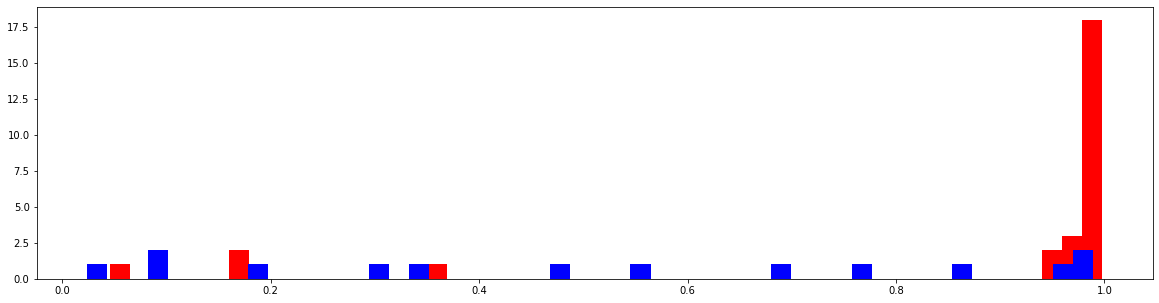

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.hist(prediction_df.query('true_label == 1')['proba1'], bins = 50, color = 'r',label ='Label 1')
plt.hist(prediction_df.query('true_label == 0')['proba1'], bins = 50, color = 'b',label ='Label 0')
plt.show()

## Submit kaggle prediction

### Test on model

In [ ]:
def test_model(loader, model, batch_size,multi_mode = False):
  """
    Method used to test a CNN on data with unknown label
    
    Args:
        loader: (DataLoader) a DataLoader wrapping a LymphoDataset
        model: (nn.Module) the neural network
        batch_size: (int) number of patients to integrate for backpropagation
        multi_data: (Boolean) whether to use all the data (images and clinical data) or not
        
    Returns:
        results_df: (pd.DataFrame) dataframe retrieveing metrics on the training during the epoch
    """
  total_loss = 0

  columns = ["patient_id", "proba0", "proba1", "pred_label"]
  df_rows = []
  with torch.no_grad():

    for idx, batch in enumerate(loader):
      bag = batch['images'].cuda()

      if multi_mode :
        lymph_count, age = batch['lymph_count'], batch['age']
        clinical_data = torch.cat((lymph_count,age), axis = 1).cuda()
        output = model(bag, clinical_data)
        #output = model(clinical_data)

      else:
        output = model(bag)

      probs = nn.Softmax(dim = 1)(output)
      _, pred = torch.max(probs, 1, keepdim = True)
    
      # storing results
      row = [batch['patient_id'][0], probs.squeeze()[0].item(), probs.squeeze()[1].item(),pred.reshape(1).item()]
      df_rows.append(row)
        
    results_df = pd.DataFrame(df_rows, columns = columns)

    return results_df


def kaggle_ypred(df):

  df = df[['patient_id','pred_label']]\
    .rename(columns = {'patient_id':'ID','pred_label':'Predicted'})\
    .set_index('ID')
  
  return df 

In [ ]:
test_results_df = test_model(test_loader, model, batch_size, multi_mode = True)
test_results_df.to_csv(EXPERIMENT_PATH+'/test_results_df.csv')
test_results_df.head()

,patient_id,proba0,proba1,pred_label
0,P71,0.543813,0.456187,0
1,P16,0.000002,0.999998,1
2,P114,0.441703,0.558297,1
3,P170,0.486696,0.513304,1
4,P98,0.754632,0.245368,0


In [ ]:
y_pred = kaggle_ypred(test_results_df)
y_pred.to_csv(EXPERIMENT_PATH+'/y_pred.csv')
y_pred.head()

,Predicted
ID,
P71,0
P16,1
P114,1
P170,1
P98,0
